In [154]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ase.units import kB
import matplotlib

In [183]:
# load RDF data and Potential data

#loads the RDF data matrix
RDF_int = np.load("../H2O_write_UQ/CEA_256int_rdf_OO.npy")
RDF_grid = np.load("../H2O_write_UQ/gridRDF_256H2O_1ns.npy")
rdf_val_256_mean = np.load("../H2O_write_UQ/CEA_256H2O_1ns_mean_OO.npy")
rdf_val_256_std = np.load("../H2O_write_UQ/CEA_256H2O_1ns_std_OO.npy")

with open('../../Atomistic_experiments/trajectories_H2O/DFT_size_extensive_MD_300K/run_256/BPNN-H2O-md.committee_pot_0', 'r') as file:
    lines = file.readlines()

dat = []
for line in lines[1::2]:
    tmp = []
    for s in line.split():
        tmp.append(float(s))
    dat.append(tmp)

dat = np.array(dat)

E_mean = np.mean(dat, axis=1)
E_UQ = np.std(dat, axis=1)

In [186]:
def CEA(obs, pot, T):
    #assuming obs is an array of shape (N_samples, N_Prop_dim)
    #and pot is an array of shape (N_samples, N_ensemble)
    # T is the temperature in K
    # returns N_ensemble weighted average obs

    beta = 1/(kB*T)
    w_obs = []
    obs_mean = np.mean(obs, axis=1)
    pot_mean = np.mean(pot, axis=1)

    #print(obs_mean.shape)
    #print(pot_mean.shape)

    for i in range(pot.shape[-1]):
        #print(np.mean(obs * (pot[:,i] - pot_mean),axis=1).shape)
        w_obs_i = obs_mean - beta * (np.mean(obs * (pot[:,i] - pot_mean),axis=1) - obs_mean * np.mean(pot[:,i] - pot_mean))
        w_obs.append(w_obs_i)

    return w_obs   

In [187]:
N_DROP = 100

w_obs = CEA(RDF_int[:,N_DROP:], dat[N_DROP:,:], 300)

w_obs= np.array(w_obs)

mean_rdf = np.mean(w_obs,axis=0)
std_rdf = np.std(w_obs,axis=0)

2.8049999999999997


/var/folders/7y/yhl65v0j5m3g8zj_xwkzq44w0000gn/T/ipykernel_89431/1164081239.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


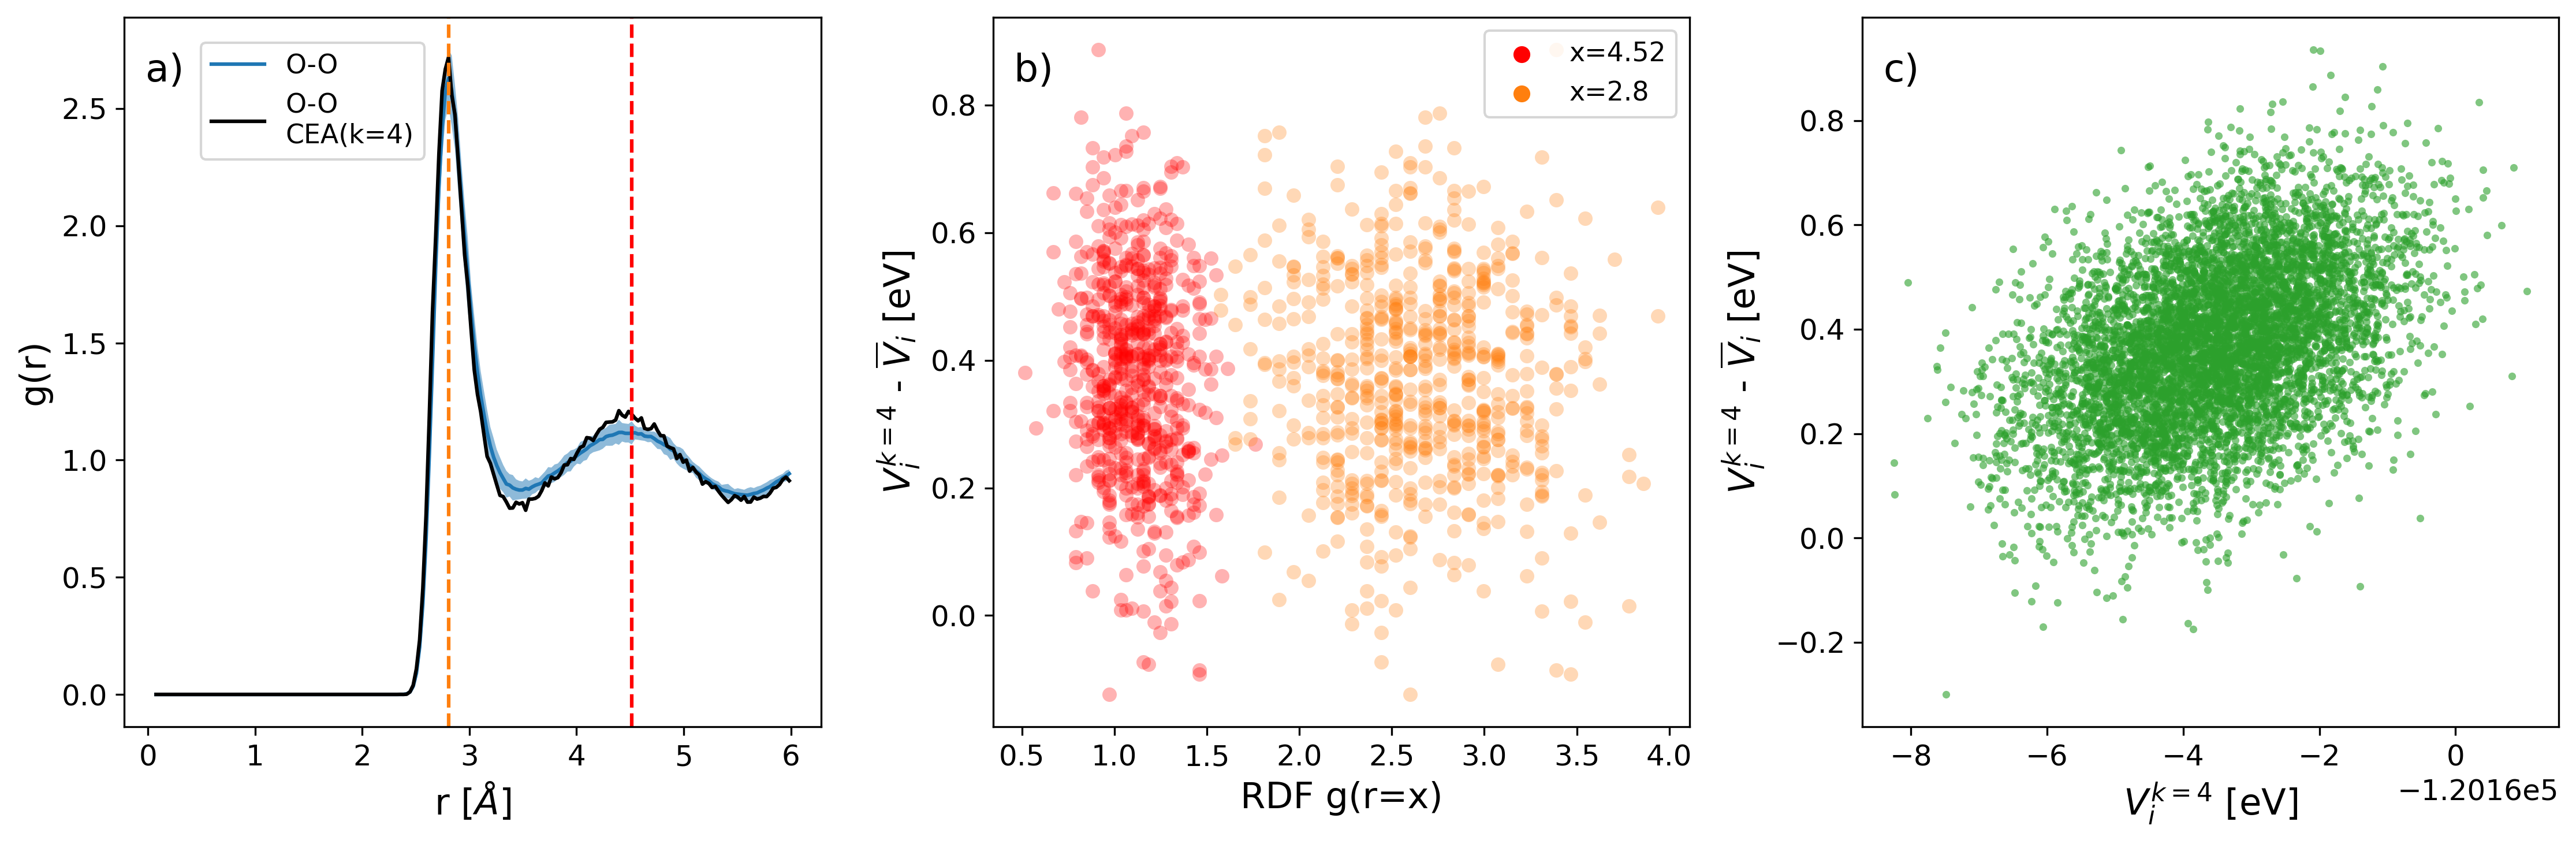

In [231]:
LINESTYLE_UNIT = "--"
COLOR_UNIT = "black"
SCATTER_SIZE = 20.
OPACITY_SCATTER = 0.8
plt.rc('axes', labelsize=13.5)
plt.rcParams.update({'font.size': 11.0})
matplotlib.rc('xtick', labelsize=12.0) 
matplotlib.rc('ytick', labelsize=12.0) 
plt.rc('axes', labelsize=15.)

N_DROP = 100

dat_int = dat[N_DROP:,32] - np.mean(dat[N_DROP:],axis=1)

COMMITTEE_MEMBER = 4

fig, ax = plt.subplots(1,3, figsize=(15,5), dpi=300)

bins_sel = [93,150]
ax[0].plot(RDF_grid[2:], np.mean(RDF_int[:,100:],axis=1)[2:], label="O-O")
ax[0].plot(RDF_grid[2:], w_obs[COMMITTEE_MEMBER][2:], label="O-O\nCEA(k={})".format(COMMITTEE_MEMBER), color="black")
ax[0].fill_between(RDF_grid[2:], rdf_val_256_mean[2:] - rdf_val_256_std[2:], rdf_val_256_mean[2:] + rdf_val_256_std[2:], alpha=0.5)
ax[0].axvline(x=RDF_grid[bins_sel[0]],  color='tab:orange', linestyle='--')
ax[0].axvline(x=RDF_grid[bins_sel[1]], color='r',  linestyle='--')
ax[0].set_xlabel("r [$\AA$]")
ax[0].set_ylabel("g(r)")
#location a bit lower then upper left
ax[0].legend(loc=(0.11,0.8))

#sns.kdeplot(x=RDF_int[bins_sel[0],N_DROP::10], y=(dat[N_DROP:,COMMITTEE_MEMBER] - np.mean(dat[N_DROP:],axis=1)).flatten()[::10],  c="tab:orange",  levels=5, ax=ax[1])
#sns.kdeplot(x=RDF_int[bins_sel[1],N_DROP::10], y=(dat[N_DROP:,COMMITTEE_MEMBER] - np.mean(dat[N_DROP:],axis=1)).flatten()[::10],  c="r",levels=5, ax=ax[1])
ax[1].scatter([],[],c="r", label="x={}".format(round(RDF_grid[bins_sel[1]],2)))
ax[1].scatter(x=RDF_int[bins_sel[1],N_DROP::10], y=(dat[N_DROP:,COMMITTEE_MEMBER] - np.mean(dat[N_DROP:],axis=1)).flatten()[::10],
              c="r", rasterized=True, alpha=0.3, linewidth=0, ) #label="x={}".format(round(RDF_grid[bins_sel[1]],2)))
ax[1].scatter([],[],c="tab:orange", label="x={}".format(round(RDF_grid[bins_sel[0]],2)))
ax[1].scatter(x=RDF_int[bins_sel[0],N_DROP::10], y=(dat[N_DROP:,COMMITTEE_MEMBER] - np.mean(dat[N_DROP:],axis=1)).flatten()[::10],
              c="tab:orange", rasterized=True, alpha=0.3, linewidth=0, ) #label="x={}".format(round(RDF_grid[bins_sel[0]],2)))

#sns.kdeplot(x=RDF_int[bin_sel,N_DROP::10], y=(dat[N_DROP:,32] - np.mean(dat[N_DROP:],axis=1)).flatten()[::10], levels=5, ax=ax[1], label="Pot 32"
#sns.kdeplot(x=RDF_int[bin_sel,N_DROP::10], y=(dat[N_DROP:,33] - np.mean(dat[N_DROP:],axis=1)).flatten()[::10], levels=5, ax=ax[1], label="Pot 33")
#sns.kdeplot(x=RDF_int[bin_sel,N_DROP::10], y=(dat[N_DROP:,34] - np.mean(dat[N_DROP:],axis=1)).flatten()[::10], levels=5,  ax=ax[1], label="Pot 34")
#sns.kdeplot(x=RDF_int[bin_sel,N_DROP::10], y=(dat[N_DROP:,35] - np.mean(dat[N_DROP:],axis=1)).flatten()[::10], levels=5,  ax=ax[1], label="Pot 35")

ax[1].set_xlabel("RDF g(r=x)")
ax[1].set_ylabel(r"$V_i^{k=" + str(COMMITTEE_MEMBER) +r"}$ - $\overline{V}_i$ [eV]")
ax[1].legend(loc="upper right")

print(RDF_grid[bins_sel[0]])

ax[2].scatter(x=dat[N_DROP:,COMMITTEE_MEMBER], y=(dat[N_DROP:,COMMITTEE_MEMBER] - np.mean(dat[N_DROP:],axis=1)).flatten(),s=10., color="tab:green", rasterized=True, alpha=0.6, linewidth=0)
ax[2].set_xlabel(r"$V_i^{k=" + str(COMMITTEE_MEMBER) +r"}$ [eV]")
ax[2].set_ylabel(r"$V_i^{k=" + str(COMMITTEE_MEMBER) +r"}$ - $\overline{V}_i$ [eV]")

# a) b) c) text in upper right hand corners
ax[0].text(0.03, 0.95, 'a)', transform=ax[0].transAxes, fontsize=16,
        verticalalignment='top')
ax[1].text(0.03, 0.95, 'b)', transform=ax[1].transAxes, fontsize=16,
        verticalalignment='top')
ax[2].text(0.03, 0.95, 'c)', transform=ax[2].transAxes, fontsize=16,
        verticalalignment='top')

#ax[1].legend()
fig.tight_layout()
fig.show()
fig.savefig("CEA_correlation.pdf")

Text(0, 0.5, '$V_i^{k=4}$ - $\\overline{V}_i$ [eV]')

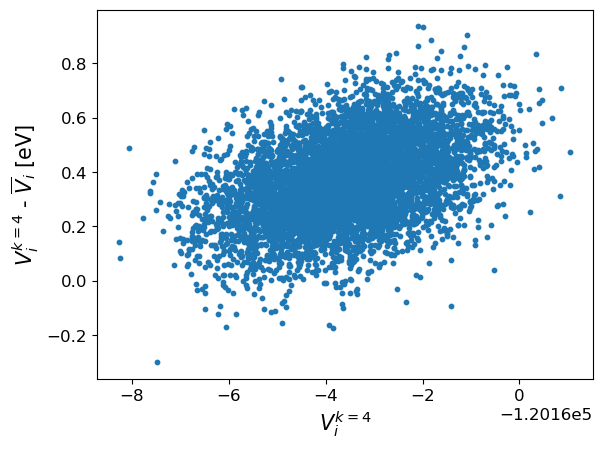

In [193]:
COMMITTEE_MEMBER = 4
plt.scatter(x=dat[N_DROP:,COMMITTEE_MEMBER], y=(dat[N_DROP:,COMMITTEE_MEMBER] - np.mean(dat[N_DROP:],axis=1)).flatten(),s=10.)
plt.xlabel(r"$V_i^{k=" + str(COMMITTEE_MEMBER) +r"}$")
plt.ylabel(r"$V_i^{k=" + str(COMMITTEE_MEMBER) +r"}$ - $\overline{V}_i$ [eV]")

/var/folders/7y/yhl65v0j5m3g8zj_xwkzq44w0000gn/T/ipykernel_89431/1518779808.py:65: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


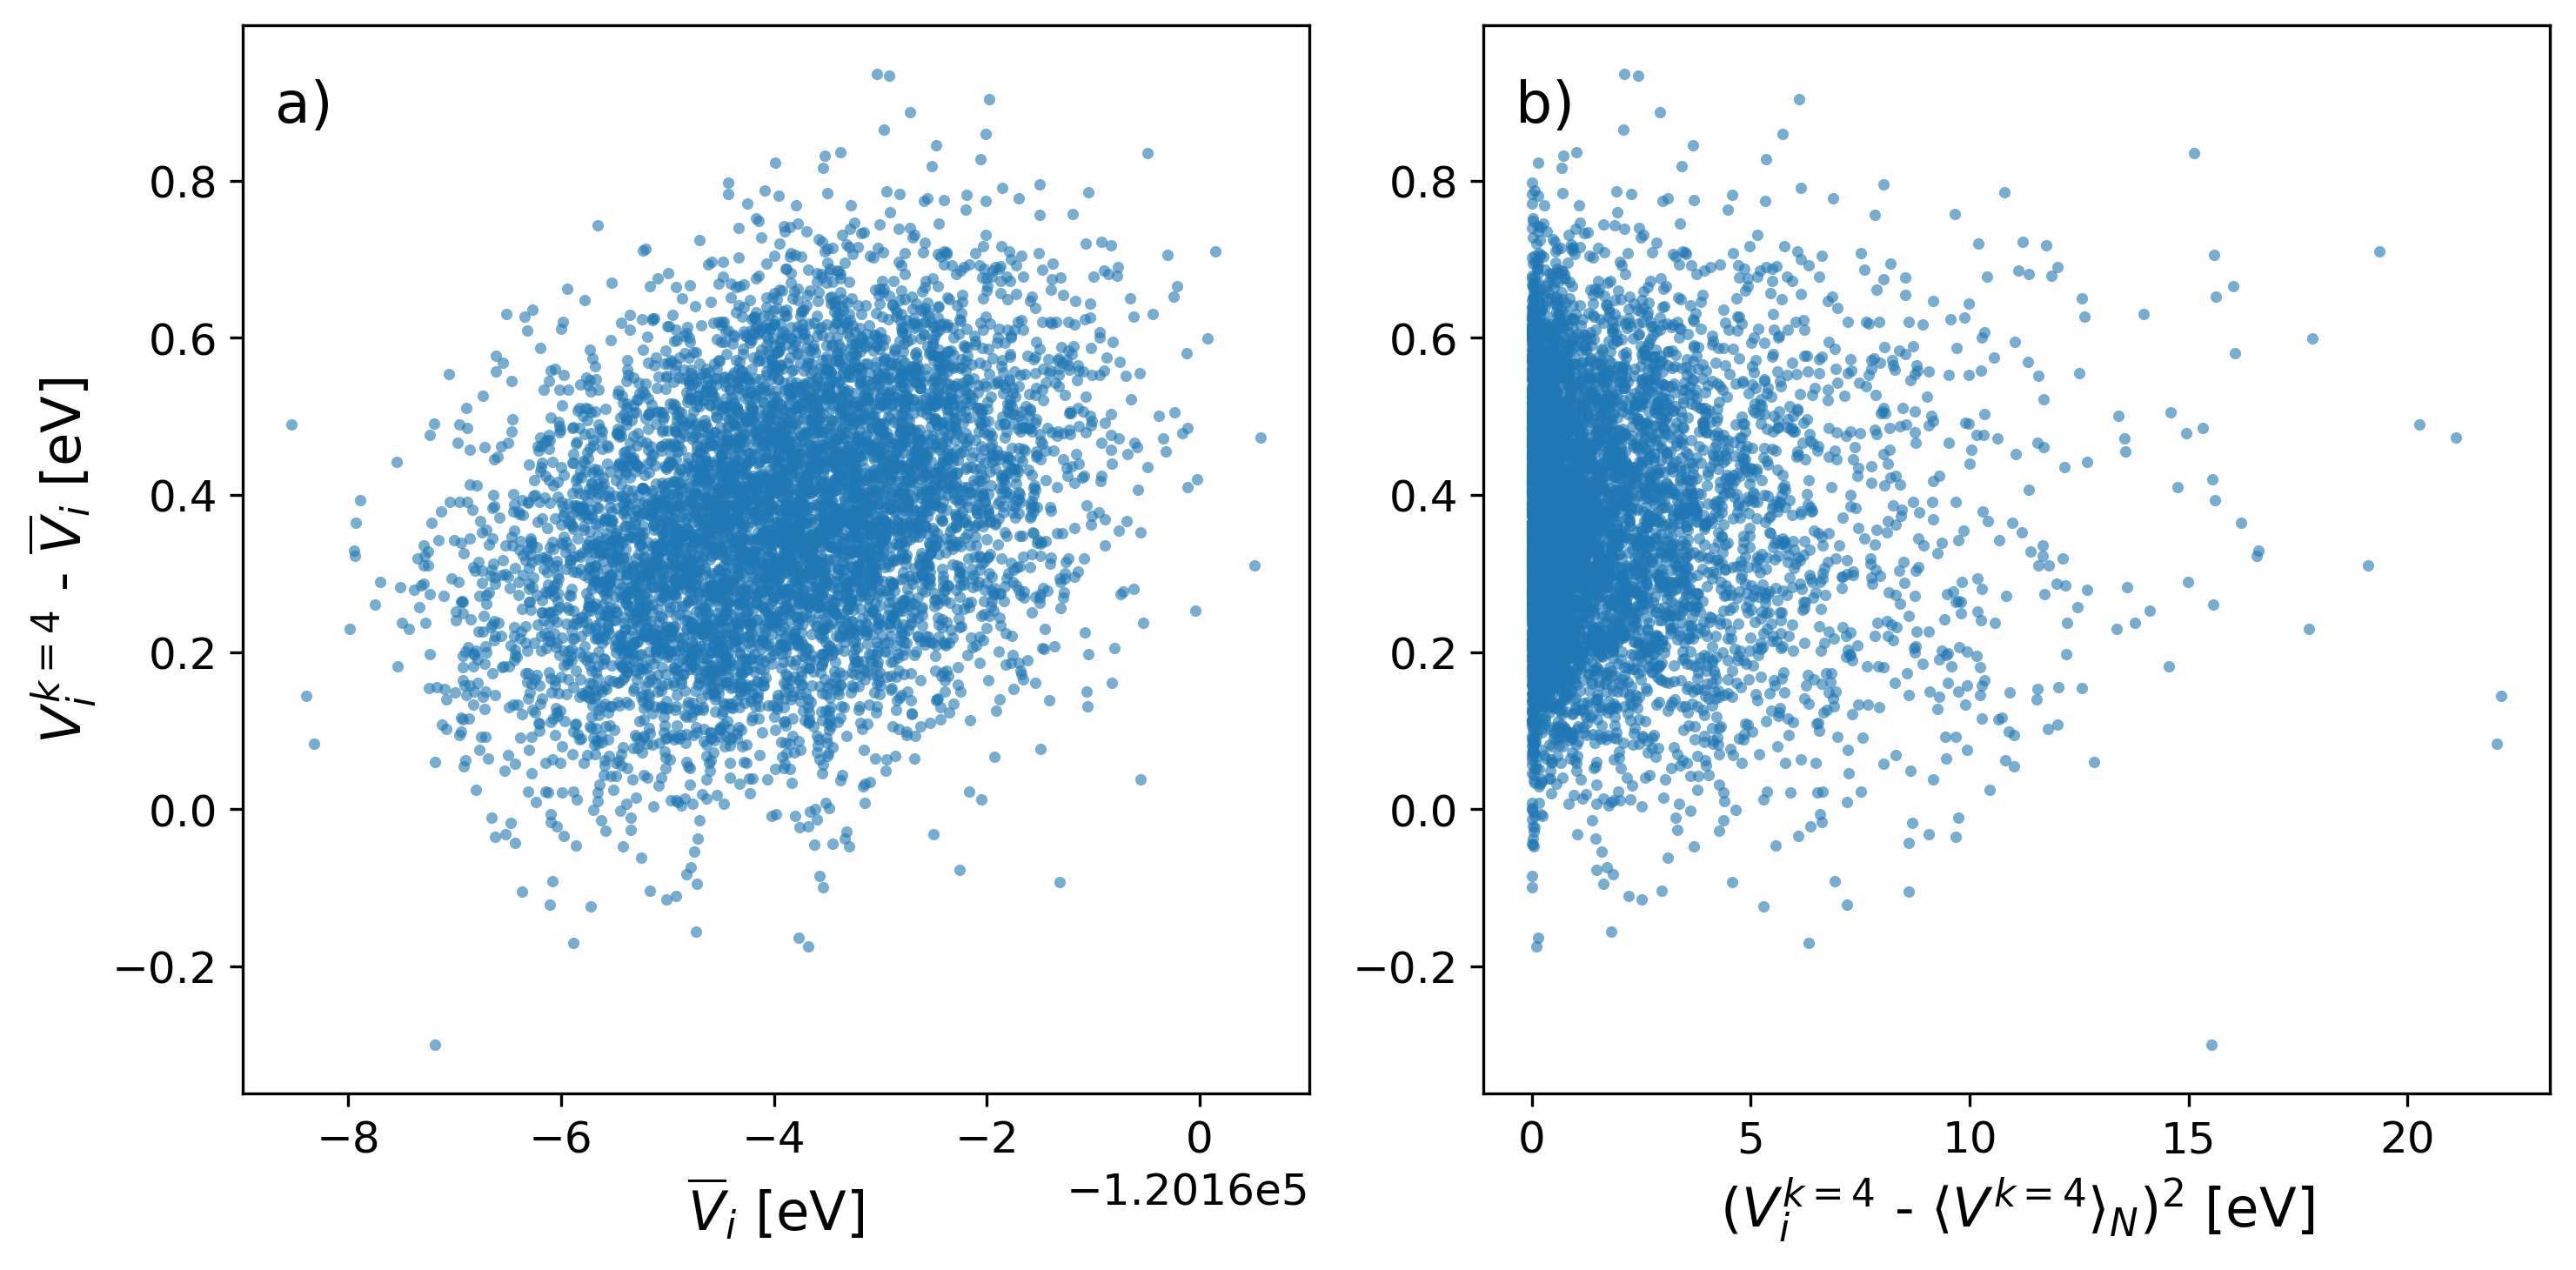

In [223]:
LINESTYLE_UNIT = "--"
COLOR_UNIT = "black"
SCATTER_SIZE = 20.
OPACITY_SCATTER = 0.8
plt.rc('axes', labelsize=13.5)
plt.rcParams.update({'font.size': 11.0})
matplotlib.rc('xtick', labelsize=12.0) 
matplotlib.rc('ytick', labelsize=12.0) 
plt.rc('axes', labelsize=15.)

N_DROP = 100
COMMITTEE_MEMBER = 4

fig, ax = plt.subplots(1,2, figsize=(10,5), dpi=300)

bins_sel = [93,150]

"""
ax[0].plot(RDF_grid[2:], np.mean(RDF_int[:,100:],axis=1)[2:])
ax[0].fill_between(RDF_grid[2:], rdf_val_256_mean[2:] - rdf_val_256_std[2:], rdf_val_256_mean[2:] + rdf_val_256_std[2:], alpha=0.5)
ax[0].axvline(x=RDF_grid[bins_sel[0]], color='r', linestyle='--')
ax[0].axvline(x=RDF_grid[bins_sel[1]], color='tab:orange', linestyle='--')
ax[0].set_xlabel("r [$\AA$]")
ax[0].set_ylabel("g(r)")
"""


#sns.kdeplot(x=np.mean(dat[N_DROP:],axis=1)[::10], y=(dat[N_DROP:,32] - np.mean(dat[N_DROP:],axis=1)).flatten()[::10], c="r", levels=5, ax=ax[0])
#sns.kdeplot(x=np.mean(dat[N_DROP:],axis=1)[::10], y=(dat[N_DROP:,COMMITTEE_MEMBER] - np.mean(dat[N_DROP:],axis=1)).flatten()[::10], c="tab:orange", levels=5, ax=ax[0])
ax[0].scatter(x=np.mean(dat[N_DROP:],axis=1), y=(dat[N_DROP:,COMMITTEE_MEMBER] - np.mean(dat[N_DROP:],axis=1)).flatten(), s=10., rasterized=True, alpha=0.6, linewidth=0)



#sns.kdeplot(x=np.mean(dat[N_DROP:],axis=1)[::10], y=(dat[N_DROP:,32] - np.mean(dat[N_DROP:],axis=1)).flatten()[::10], c="r", levels=5, ax=ax[0])
#sns.kdeplot(x=np.mean(dat[N_DROP:],axis=1)[::10], y=(dat[N_DROP:,32] - np.mean(dat[N_DROP:],axis=1)).flatten()[::10], c="tab:orange", levels=5, ax=ax[0])

#sns.kdeplot(x=RDF_int[bin_sel,N_DROP::10], y=(dat[N_DROP:,33] - np.mean(dat[N_DROP:],axis=1)).flatten()[::10], levels=5, ax=ax[1], label="Pot 33")
#sns.kdeplot(x=RDF_int[bin_sel,N_DROP::10], y=(dat[N_DROP:,34] - np.mean(dat[N_DROP:],axis=1)).flatten()[::10], levels=5,  ax=ax[1], label="Pot 34")
#sns.kdeplot(x=RDF_int[bin_sel,N_DROP::10], y=(dat[N_DROP:,35] - np.mean(dat[N_DROP:],axis=1)).flatten()[::10], levels=5,  ax=ax[1], label="Pot 35")

ax[0].set_xlabel("$\overline{V}_i$ [eV]")
ax[0].set_ylabel(r"$V_i^{k=" + str(COMMITTEE_MEMBER) + r"}$ - $\overline{V}_i$ [eV]")

#sns.kdeplot(x=((dat[N_DROP:,COMMITTEE_MEMBER].flatten()  - np.mean(dat[N_DROP:,COMMITTEE_MEMBER]))**2)[::10], y=(dat[N_DROP:,COMMITTEE_MEMBER] - np.mean(dat[N_DROP:],axis=1)).flatten()[::10], c="tab:orange", levels=5, ax=ax[1])

ax[1].scatter(x=((dat[N_DROP:,COMMITTEE_MEMBER].flatten()  - np.mean(dat[N_DROP:,COMMITTEE_MEMBER]))**2), y=(dat[N_DROP:,COMMITTEE_MEMBER] - np.mean(dat[N_DROP:],axis=1)).flatten(), rasterized=True, alpha=0.6, s=10., linewidth=0)
#sns.kdeplot(x=((dat[N_DROP:,32].flatten()  - np.mean(dat[N_DROP:,32],axis=0))**2)[::10], y=(dat[N_DROP:,32] - np.mean(dat[N_DROP:],axis=1)).flatten()[::10], c="r", levels=5, ax=ax[1])
#sns.kdeplot(x=np.mean(dat[N_DROP:],axis=1)[::10], y=(dat[N_DROP:,32] - np.mean(dat[N_DROP:],axis=1)).flatten()[::10], c="tab:orange", levels=5, ax=ax[1])
ax[1].set_xlabel(r"($V_i^{k=" + str(COMMITTEE_MEMBER) + r"}$ - $\langle V^{k=" + str(COMMITTEE_MEMBER) + r"} \rangle_N)^2$ [eV]")
#sns.kdeplot(x=np.mean(dat[N_DROP:],axis=1)[::10], y=(dat[N_DROP:,32] - np.mean(dat[N_DROP:],axis=1)).flatten()[::10], c="r", levels=5, ax=ax[1])
#sns.kdeplot(x=np.mean(dat[N_DROP:],axis=1)[::10], y=(dat[N_DROP:,32] - np.mean(dat[N_DROP:],axis=1)).flatten()[::10], c="tab:orange", levels=5, ax=ax[1])
#ax[1].legend()

#shared y axis of the two plots
ax[1].set_ylim(ax[0].get_ylim())

# a) b) text in upper right hand corners
ax[0].text(0.03, 0.95, 'a)', transform=ax[0].transAxes, fontsize=16,
        verticalalignment='top')
ax[1].text(0.03, 0.95, 'b)', transform=ax[1].transAxes, fontsize=16,
        verticalalignment='top')


fig.tight_layout()
fig.show()
fig.savefig("CEA_correlation_potential.pdf", bbox_inches='tight')